En este cuaderno se detallan todos los pasos seguidos para generar soluciones, calcular indicadores de calidad, obtener tablas y hacer el análisis estadístico de los resultados

In [1]:
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm as tqm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from utils.func_aux import *
from utils.cd_plots import *

import plotly.express as px
import scipy.stats as st
import seaborn as sns
import pandas as pd
import numpy as np
import shutil
import time 
import os
from utils.func_vis import *

# Opciones de matplotlib
rc = plt.rcParams
rc["figure.figsize"] = [15, 5]

# Para mostrar todas las columnas cuando se imprime un df
pd.set_option("display.max_columns", None)

# Para poner el estilo de las gráficas de matplotlib parecido al de ggplot
plt.style.use("ggplot") 


In [9]:
df_todos_PI

problema Indicador    w_0  dimension  run  Valor_Indicador divers_QI
0          WFG9      eps+  0.001          3    0         0.217718      IGD+
1          WFG9      eps+  0.001          3    1         0.240986      IGD+
2          WFG9      eps+  0.001          3    2         0.240616      IGD+
3          WFG9      eps+  0.001          3    3         0.236098      IGD+
4          WFG9      eps+  0.001          3    4         0.267390      IGD+
...         ...       ...    ...        ...  ...              ...       ...
147835     WFG9        hv  0.999          6    5     93347.990000        R2
147836     WFG9        hv  0.999          6    6     97336.020000        R2
147837     WFG9        hv  0.999          6    7     95928.310000        R2
147838     WFG9        hv  0.999          6    8     98113.420000        R2
147839     WFG9        hv  0.999          6    9    103999.800000        R2

[147840 rows x 7 columns]

In [2]:
# dado un problema, una n_objetivos, un w_0 y un ind_conv, agarramos el que está en la mediana de algún indicador que por default es el hipervolumen


def get_sol(problema, n_objetivos, w0, run, ind_conv="IGDp", nd=True):
    '''Devuelve un df con la solución después de leer el archivo'''
    go_to_Assesment()

    cadena = f"../archivos_w_{ind_conv}/w_0{w0}/PCUIEMOA_{problema.upper()}_{str(n_objetivos).zfill(2)}D_R{str(run).zfill(2)}.pof"

    if nd:
        cadena += ".nd"

    df = pd.read_csv(cadena, sep=" ").reset_index().iloc[:, :n_objetivos]
    df.columns = [f"f{i}" for i in range(len(df.columns))]
    return df

problema='DTLZ3'
n_objetivos=3
w_0=0
ind_conv='IGD+'
ind_mediana='HV'

def get_run_mediana(problema: str,n_objetivos: int,w_0 : int,ind_mediana, ind_conv ='IGD+'):
    '''Toma un representante con un desempeño intermedio (usando la mediana) de un problema, n_objetivos, w_0, ind_conv e ind_mediana
    Args:
        problema (str): 
        n_objetivos (int): 
        w_0 (int):
        ind_mediana (str): 
        ind_conv (str): 
    return: int
    
    '''
    run_mediana=df_todos_PI.query(f'(divers_QI=="{ind_conv}")&(problema=="{problema}")&(indicador=="{ind_mediana.lower()}") &(n_objetivos=={n_objetivos}) &(w_0=={w_0_todos[w_0]})').sort_values('valor_indicador').iloc[5].run

    return run_mediana
go_to_Assesment()
# path_pof=f'../archivos_w_{ind_conv}/w_0{w_0}'
# os.path.exists(path_pof)

w_0_todos=np.sort(df_todos_PI.w_0.unique())

def get_sol_path_Assesment(path, n_objetivos):
    """Obtener df de la solución"""
    go_to_Assesment()

    df = pd.read_csv(path, sep=" ").reset_index().iloc[:, :n_objetivos] # Se hace esto porque salen más n_objetivoses de las que tiene el problema
    df.columns = [f"f{i}" for i in range(len(df.columns))]
    return df

def get_sol_mediana(problema,n_objetivos,w_0,ind_conv,ind_mediana):
    run=get_run_mediana(problema,n_objetivos,w_0,ind_conv,ind_mediana)+1
    if ind_conv=='IGD+':
        ind_conv='IGDp'
    return get_sol_path_Assesment(path=f'../archivos_w_{ind_conv}/w_0{w_0}/PCUIEMOA_{problema}_{str(n_objetivos).zfill(2)}D_R{str(run).zfill(2)}.pof',n_objetivos=n_objetivos)



df_sol_med=get_sol_mediana(problema,n_objetivos,w_0,ind_conv,ind_mediana)

# Para hacer el grid tengo que hacer una fila de 4 x 3 o 3 x 4
# conseguir las mediandas de todos los w_0s

def get_all_medianas(problema,n_objetivos,ind_conv,ind_mediana):
    dfs=[]
    for w_0 in range(len(w_0_todos)):
        df=get_sol_mediana(problema,n_objetivos,w_0,ind_conv,ind_mediana)
        dfs.append(df)
    return dfs

df_s=get_all_medianas(problema,n_objetivos,ind_conv,ind_mediana)

In [7]:
def PCP_malla(dfs,path_save=None):
    
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(4, 3, figsize=(12, 12))
    axes = axes.flatten()

    # Loop over the DataFrames and axes to create each subplot
    j=0
    for ax, df in zip(axes, dfs):
        # Normalize the DataFrame for easier plotting
        
        # Get the number of features (i.e., columns)
        n_features = len(df.columns)
        
        # Plot each line
        for i in range(len(df)):
            ax.plot(range(n_features), df.iloc[i,:],color='k',alpha=0.5)
            
        # Set the tick labels to the column names
        ax.set_xticks(range(n_features))
        ax.set_xticklabels(df.columns)
        
        # Add grid lines and title
        ax.grid(True)
        ax.set_title(f"$w_0={w_0_todos[j]:2.2f}$")
        j+=1
    # plt.suptitle(f'Malla para {problema} con {n_objetivos} objetivos')

    if path_save is not None:
        path=f'{path_save[:-3]}_PCP.pdf'
    
        plt.savefig(path)

    plt.show()

'HV'

Se encontró el conjunto de referencia en Assessment


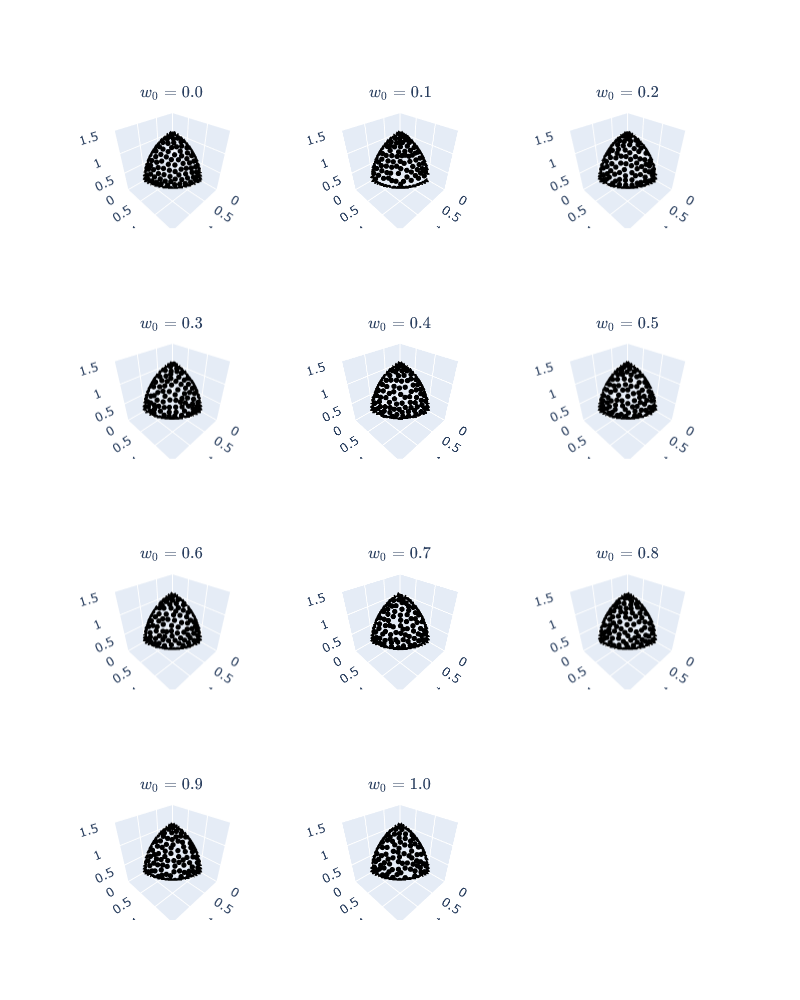

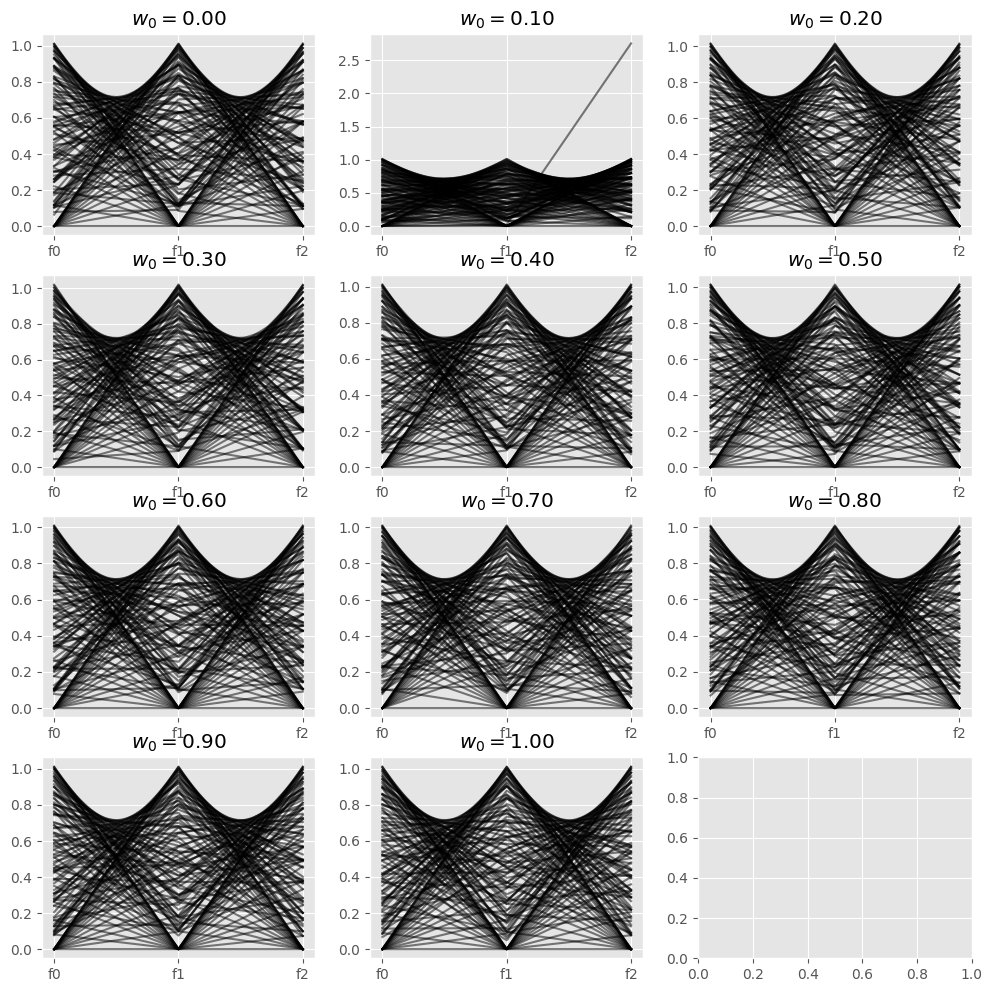

In [23]:

def plot_pareto_sol_grid(problema,n_objetivos,ind_conv,ind_mediana,df_pareto=None,path_save=None):

    dfs=get_all_medianas(problema,n_objetivos,ind_conv,ind_mediana)
    rows,cols=4,3

    color_palette = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', 
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', 
    '#cab2d6', '#6a3d9a', '#ffff99'
    ]
    try:
        maxs=get_problem(name=problema,nobjs=3).nadir_point()*1.5
    except: 
        maxs=np.ones(n_objetivos)*1.1

    conjunto_pareto(problema=problema,n_objetivos=n_objetivos)
    titles=[f'$w_0={round(wi,2)}$' for wi in w_0_todos]

    if n_objetivos == 2:
        specs = [[{'type': 'scatter'} for _ in range(cols)] for _ in range(rows)]
    
        fig=make_subplots(rows=4,cols=3,specs=specs,subplot_titles=titles)

        if df_pareto is not None:
            trace_1 = go.Scatter(
                x=df_pareto["f0"],
                y=df_pareto["f1"],
                # mode="markers",
                # marker=dict(size=5, color="blue", opacity=0.7),
                name="Referencia PF",
            )

        for i,df in enumerate(dfs):
            fig.add_trace(go.Scatter(x=df['f0'],y=df['f1'],mode='markers',name=f'w_0={w_0_todos[i]:2.2f}',marker=dict(color=color_palette[i])),row=i//cols+1,col=i%cols+1)
        fig.update_layout(height=800, width=800, title_text=f"Malla para {problema} en {n_objetivos} objetivos")
        fig.show(renderer='png')

    elif n_objetivos == 3:
        specs = [[{'type': 'scatter3d'} for _ in range(cols)] 
                 for _ in range(rows)]
        fig=make_subplots(rows=4,cols=3,specs=specs,subplot_titles=titles)
        if df_pareto is not None:
            trace_set1 = go.Scatter3d(
                x=df_pareto["f0"],
                y=df_pareto["f1"],
                z=df_pareto["f2"],
                mode="markers",
                marker=dict(
                    size=5,
                    color="blue",
                    opacity=0.7,
                ),
                name="Referencia PF",
            )

        for i,df in enumerate(dfs):
            row,col=i//cols+1,i%cols+1

            fig.add_trace(go.Scatter3d(x=df['f0'],y=df['f1'],z=df['f2'], mode='markers',name=f'w_0={w_0_todos[i]:2.2f}',marker=dict(color='black',size=3)),row=row,col=col)
            
            
            fig.update_scenes(
                aspectmode='cube',
                xaxis=dict(range=[0, maxs[0]]), 
                yaxis=dict(range=[0, maxs[1]]), 
                zaxis=dict(range=[0, maxs[2]]),
                row=row,col=col
            )
            # print(row,col)
        fig.update_layout(height=1000, width=800,showlegend=False)
        fig.show(renderer='png')

        if path_save is not None:
            fig.write_image(file=path_save,format='pdf')



        PCP_malla(dfs, path_save)

    else:
        # Hay d(d-1)/2 plots, de dos por renglón
        n_plots = n_objetivos * (n_objetivos - 1) / 2
        ncols = 3
        nrows = int(np.ceil(n_plots / ncols))
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))

        k = 0
        for i in range(n_objetivos):
            for j in range(i + 1, n_objetivos):
                row = k // ncols
                col = k % ncols
                axi = ax[row, col]
                axi.set_xlabel(f"$f_{i}$", size=15)
                axi.set_ylabel(f"$f_{j}$", size=15)
                axi.scatter(
                    df_pareto.iloc[:, i],
                    df_pareto.iloc[:, j],
                    label="Referencia de PF",
                    s=4,
                )

                axi.scatter(
                    df_sol.iloc[:, i], df_sol.iloc[:, j], label="Aproximación al PF"
                )
                axi.legend()
                k += 1
        plt.suptitle(f"{problema} n_objetivos {n_objetivos}")
        plt.show()

        PCP_malla(dfs, path_save)

    return


plot_pareto_sol_grid(problema,3,ind_conv,ind_mediana,path_save='../imgs_pdf/DTLZ3_obj_3_alg_IGD+_indmed_HV_malla.pdf')



# Graficando las soluciones


## Obteniendo Pareto


## Obteniendo soluciones


Poner las soluciones en archivos_w para ambos problemas y ver si se pueden poner universales en algún directorio en vez de tener una copia por ambos.

In [38]:
# plot_prob(problema='WFG2',n_objetivos=3,run=1,nom_prob='WFG2',w0=0,ind_conv='IGDp')

In [40]:
# plot_prob(problema='WFG2',n_objetivos=3,run=1,nom_prob='WFG2',ind_conv='R2')

Se encontró el conjunto de referencia en Assessment


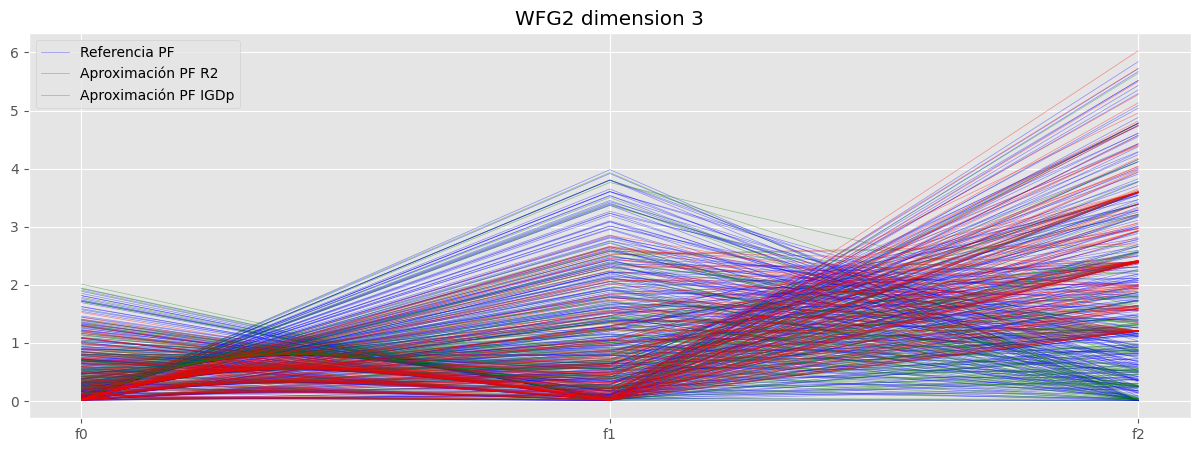

In [41]:

def get_sol_both(problema, n_objetivos, w0=0, run=1,  nd=False):
    go_to_Assesment()

    cadena_R2 = f"../archivos_w_R2/w_0{w0}/PCUIEMOA_{problema.upper()}_{str(n_objetivos).zfill(2)}D_R{str(run).zfill(2)}.pof"
    cadena_IGDp = f"../archivos_w_IGDp/w_0{w0}/PCUIEMOA_{problema.upper()}_{str(n_objetivos).zfill(2)}D_R{str(run).zfill(2)}.pof"

    if nd:
        cadena += ".nd"

    df_R2 = pd.read_csv(cadena_R2, sep=" ").reset_index().iloc[:, :n_objetivos]
    df_R2.columns = [f"f{i}" for i in range(len(df_R2.columns))]
    df_R2['ind_conv']='R2'

    df_IGDp = pd.read_csv(cadena_IGDp, sep=" ").reset_index().iloc[:, :n_objetivos]
    df_IGDp.columns = [f"f{i}" for i in range(len(df_IGDp.columns))]
    df_IGDp['ind_conv']='IGDp'

    return pd.concat([df_R2,df_IGDp])


def PCP_both(df_pareto, df_sol, problema, n_objetivos):
    plt.title(f"{problema} n_objetivos {n_objetivos}")

    for i, row in df_pareto.iterrows():
        if i == 1:
            plt.plot(row, c="b", alpha=0.4, linewidth=0.5, label="Referencia PF")
        else:
            plt.plot(row, c="b", alpha=0.4, linewidth=0.5)

    for i, row in df_sol.iterrows():
        
        if i == 1:
            if row['ind_conv']=='IGDp':
                plt.plot(row.iloc[:-1], c="r", alpha=0.4, linewidth=0.5, label="Aproximación PF IGDp")
            else:
                plt.plot(row.iloc[:-1], c="g", alpha=0.4, linewidth=0.5, label="Aproximación PF R2")
        else:
            if row['ind_conv']=='IGDp':
                plt.plot(row.iloc[:-1], c="r", alpha=0.4, linewidth=0.5)
            else:
                plt.plot(row.iloc[:-1], c="g", alpha=0.4, linewidth=0.5)

    plt.legend()


def plot_pareto_sol_both(df_pareto, df_sol, problema):
    n_objetivos = len(df_pareto.columns)

    df_sol_IGDp=df_sol.query('ind_conv=="IGDp"')
    df_sol_R2=df_sol.query('ind_conv=="R2"')

    if n_objetivos == 2:
        trace_1 = go.Scatter(
            x=df_pareto["f0"],
            y=df_pareto["f1"],
            mode="markers",
            marker=dict(size=5, color="blue", opacity=0.7),
            name="Referencia PF",
        )
        trace_2 = go.Scatter(
            x=df_sol_IGDp["f0"],
            y=df_sol_IGDp["f1"],
            mode="markers",
            marker=dict(size=5, color="red", opacity=0.7),
            name="Aproximación PF IGDp",
        )
        trace_3 = go.Scatter(
            x=df_sol_R2["f0"],
            y=df_sol_R2["f1"],
            mode="markers",
            marker=dict(size=5, color="green", opacity=0.7),
            name="Aproximación PF R2",
        )

        fig = go.Figure(data=[trace_1, trace_2,trace_3])
        fig.update_layout(
            title=f"Aproximación PF \n{problema} {n_objetivos}",
            height=500,
            width=500,
        )

        fig.show()

    elif n_objetivos == 3:
        trace_set1 = go.Scatter3d(
            x=df_pareto["f0"],
            y=df_pareto["f1"],
            z=df_pareto["f2"],
            mode="markers",
            marker=dict(
                size=5,
                color="blue",
                opacity=0.7,
            ),
            name="Referencia PF",
        )
        trace_set2 = go.Scatter3d(
            x=df_sol_IGDp["f0"],
            y=df_sol_IGDp["f1"],
            z=df_sol_IGDp["f2"],
            mode="markers",
            marker=dict(
                size=5,
                color="red",
                opacity=0.7,
            ),
            name="Aproximación PF IGD+",
        )

        trace_set3 = go.Scatter3d(
            x=df_sol_R2["f0"],
            y=df_sol_R2["f1"],
            z=df_sol_R2["f2"],
            mode="markers",
            marker=dict(
                size=5,
                color="green",
                opacity=0.7,
            ),
            name="Aproximación PF R2",
        )

        layout = go.Layout(
            scene=dict(
                xaxis=dict(title="f0"), yaxis=dict(title="f1"), zaxis=dict(title="f2")
            ),
            margin=dict(l=0, r=0, b=0, t=0),
        )
        fig = go.Figure(data=[trace_set1, trace_set2,trace_set3], layout=layout)
        fig.update_layout(
            title=f"Aproximación al frente de Pareto\n{problema} {n_objetivos} run",
            height=500,
            width=500,
        )

        fig.show()

        PCP_both(df_pareto, df_sol, problema, n_objetivos)

    else:
        # Hay d(d-1)/2 plots, de dos por renglón
        n_plots = n_objetivos * (n_objetivos - 1) / 2
        ncols = 3
        nrows = int(np.ceil(n_plots / ncols))
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))

        k = 0
        for i in range(n_objetivos):
            for j in range(i + 1, n_objetivos):
                row = k // ncols
                col = k % ncols
                axi = ax[row, col]
                axi.set_xlabel(f"$f_{i}$", size=15)
                axi.set_ylabel(f"$f_{j}$", size=15)
                axi.scatter(
                    df_pareto.iloc[:, i],
                    df_pareto.iloc[:, j],
                    label="Referencia de PF",
                    s=4,
                )

                axi.scatter(
                    df_sol_IGDp.iloc[:, i], df_sol_IGDp.iloc[:, j], label="Aproximación al PF IGDp",color='b',s=8
                )
                axi.scatter(
                    df_sol_R2.iloc[:, i], df_sol_R2.iloc[:, j], label="Aproximación al PF R2",color='g',s=8
                )
                axi.legend()
                k += 1
        plt.suptitle(f"{problema} n_objetivos {n_objetivos}")
        plt.show()

        PCP_both(df_pareto, df_sol, problema, n_objetivos)

    return


def plot_prob_both(
    problema, n_objetivos, nom_prob="Problema", w0=0, run=1, ind_conv="IGDp", nd=False
):
    df_pareto = conjunto_pareto(problema=problema, n_objetivos=n_objetivos)
    df_sol = get_sol(
        problema=problema, n_objetivos=n_objetivos, w0=w0, run=run, ind_conv=ind_conv, nd=nd
    )

    plot_pareto_sol_both(df_pareto, df_sol, problema=nom_prob)

df_sol=get_sol_both(problema='WFG2',n_objetivos=3)
# PCP_both(df_pareto=conjunto_pareto(problema='WFG2',n_objetivos=3),df_sol=df_sol,problema='WFG2',n_objetivos=3)
plot_pareto_sol_both(df_pareto=conjunto_pareto(problema='WFG2',n_objetivos=3),df_sol=df_sol,problema='WFG2')


# Boxplots


Se leen el archivo `todos_PI.csv` de todos los indicadores y se crean los boxplots. Se puede hacer hover en algún punto para ver a qué run pertenece y con esto saber qué graficar para ver qué está sucediendo

In [42]:
get_boxplot("WFG4", 2, "IGD+",df_PI=df_todos_PI_R2)
get_boxplot("WFG4", 2, "IGD+",df_PI=df_todos_PI_IGDp)


Hacemos merge para poder visualizar mejor ambas soluciones

In [43]:
df_todos_PI=pd.read_csv('../tablas_generadas/todos_QI.csv')
df_todos_PI=df_todos_PI.rename(columns={'divers_QI':'ind_conv'})
df_todos_PI

problema Indicador    w_0  dimension  run  Valor_Indicador ind_conv
0          WFG9      eps+  0.001          3    0         0.217718     IGD+
1          WFG9      eps+  0.001          3    1         0.240986     IGD+
2          WFG9      eps+  0.001          3    2         0.240616     IGD+
3          WFG9      eps+  0.001          3    3         0.236098     IGD+
4          WFG9      eps+  0.001          3    4         0.267390     IGD+
...         ...       ...    ...        ...  ...              ...      ...
147835     WFG9        hv  0.999          6    5     93347.990000       R2
147836     WFG9        hv  0.999          6    6     97336.020000       R2
147837     WFG9        hv  0.999          6    7     95928.310000       R2
147838     WFG9        hv  0.999          6    8     98113.420000       R2
147839     WFG9        hv  0.999          6    9    103999.800000       R2

[147840 rows x 7 columns]

In [47]:
def get_both_boxplots(
    problema, n_objetivos, indicador, df_PI=df_todos_PI, save_img_path=""
):
    fig = px.box(
        df_PI[
            (df_PI["n_objetivos"] == n_objetivos)
            & (df_PI["problema"] == problema)
            & (df_PI["indicador"] == indicador.lower())
        ],
        x="w_0",
        y="valor_indicador",
        hover_data=["run"],
        color='ind_conv'
    )
    fig.update_layout(
        # title=f"{problema}. Número de objetivos: {n_objetivos}. \nindicador: {indicador}",
        xaxis_title="$w_0$",
        yaxis_title=f"{indicador}",
        height=500,
        width=900,
    )
    if len(save_img_path) > 0:
        fig.write_image(save_img_path)
    else:
        fig.show()

get_both_boxplots("WFG4", 3, "hv",save_img_path='../imgs_pdf/WFG4_3obj_HV.pdf')

Se encontró el conjunto de referencia en Assessment


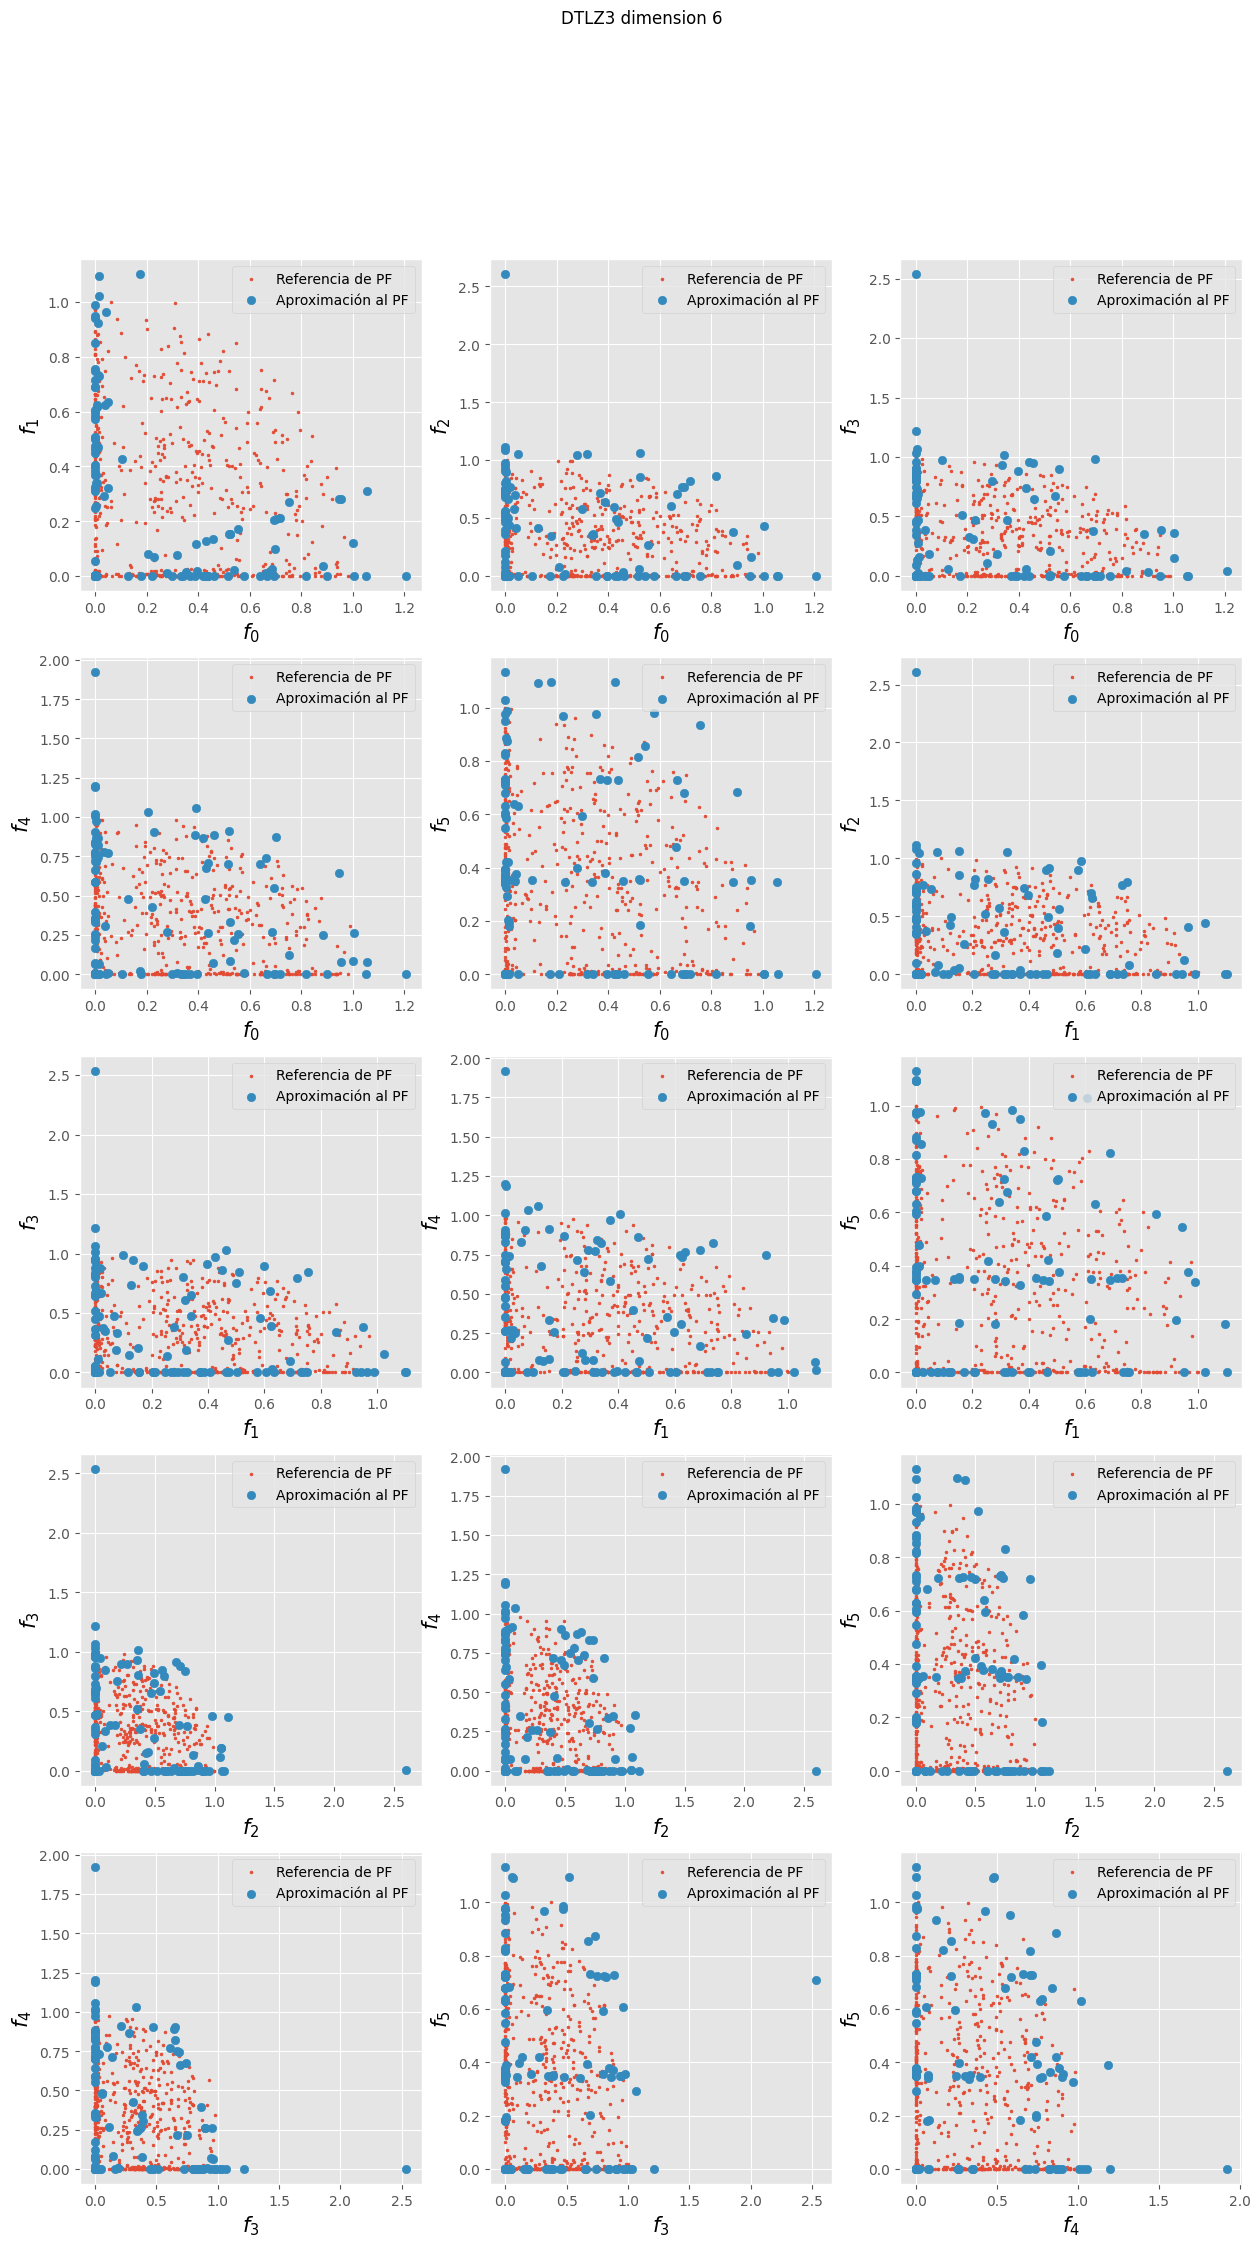

Se encontró el conjunto de referencia en Assessment


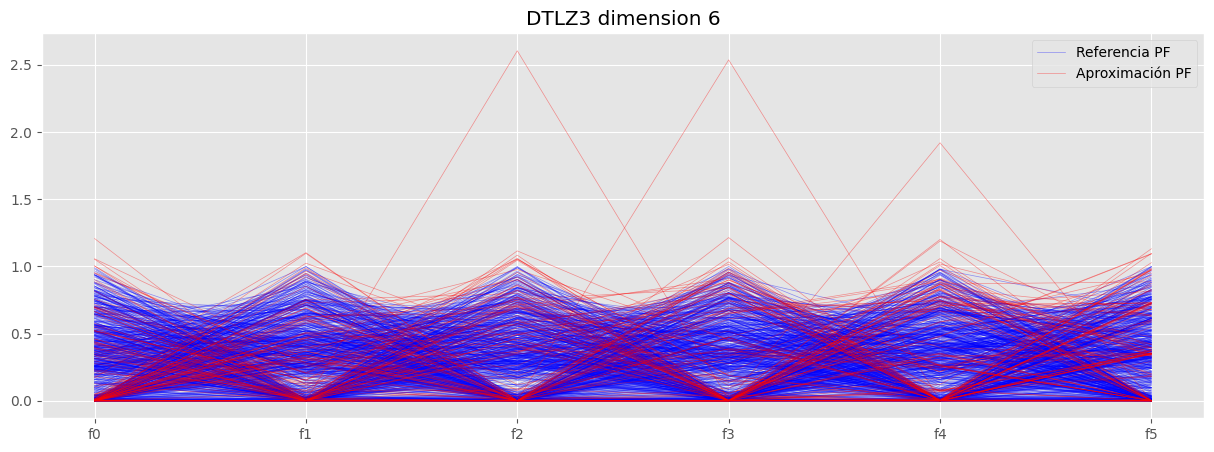

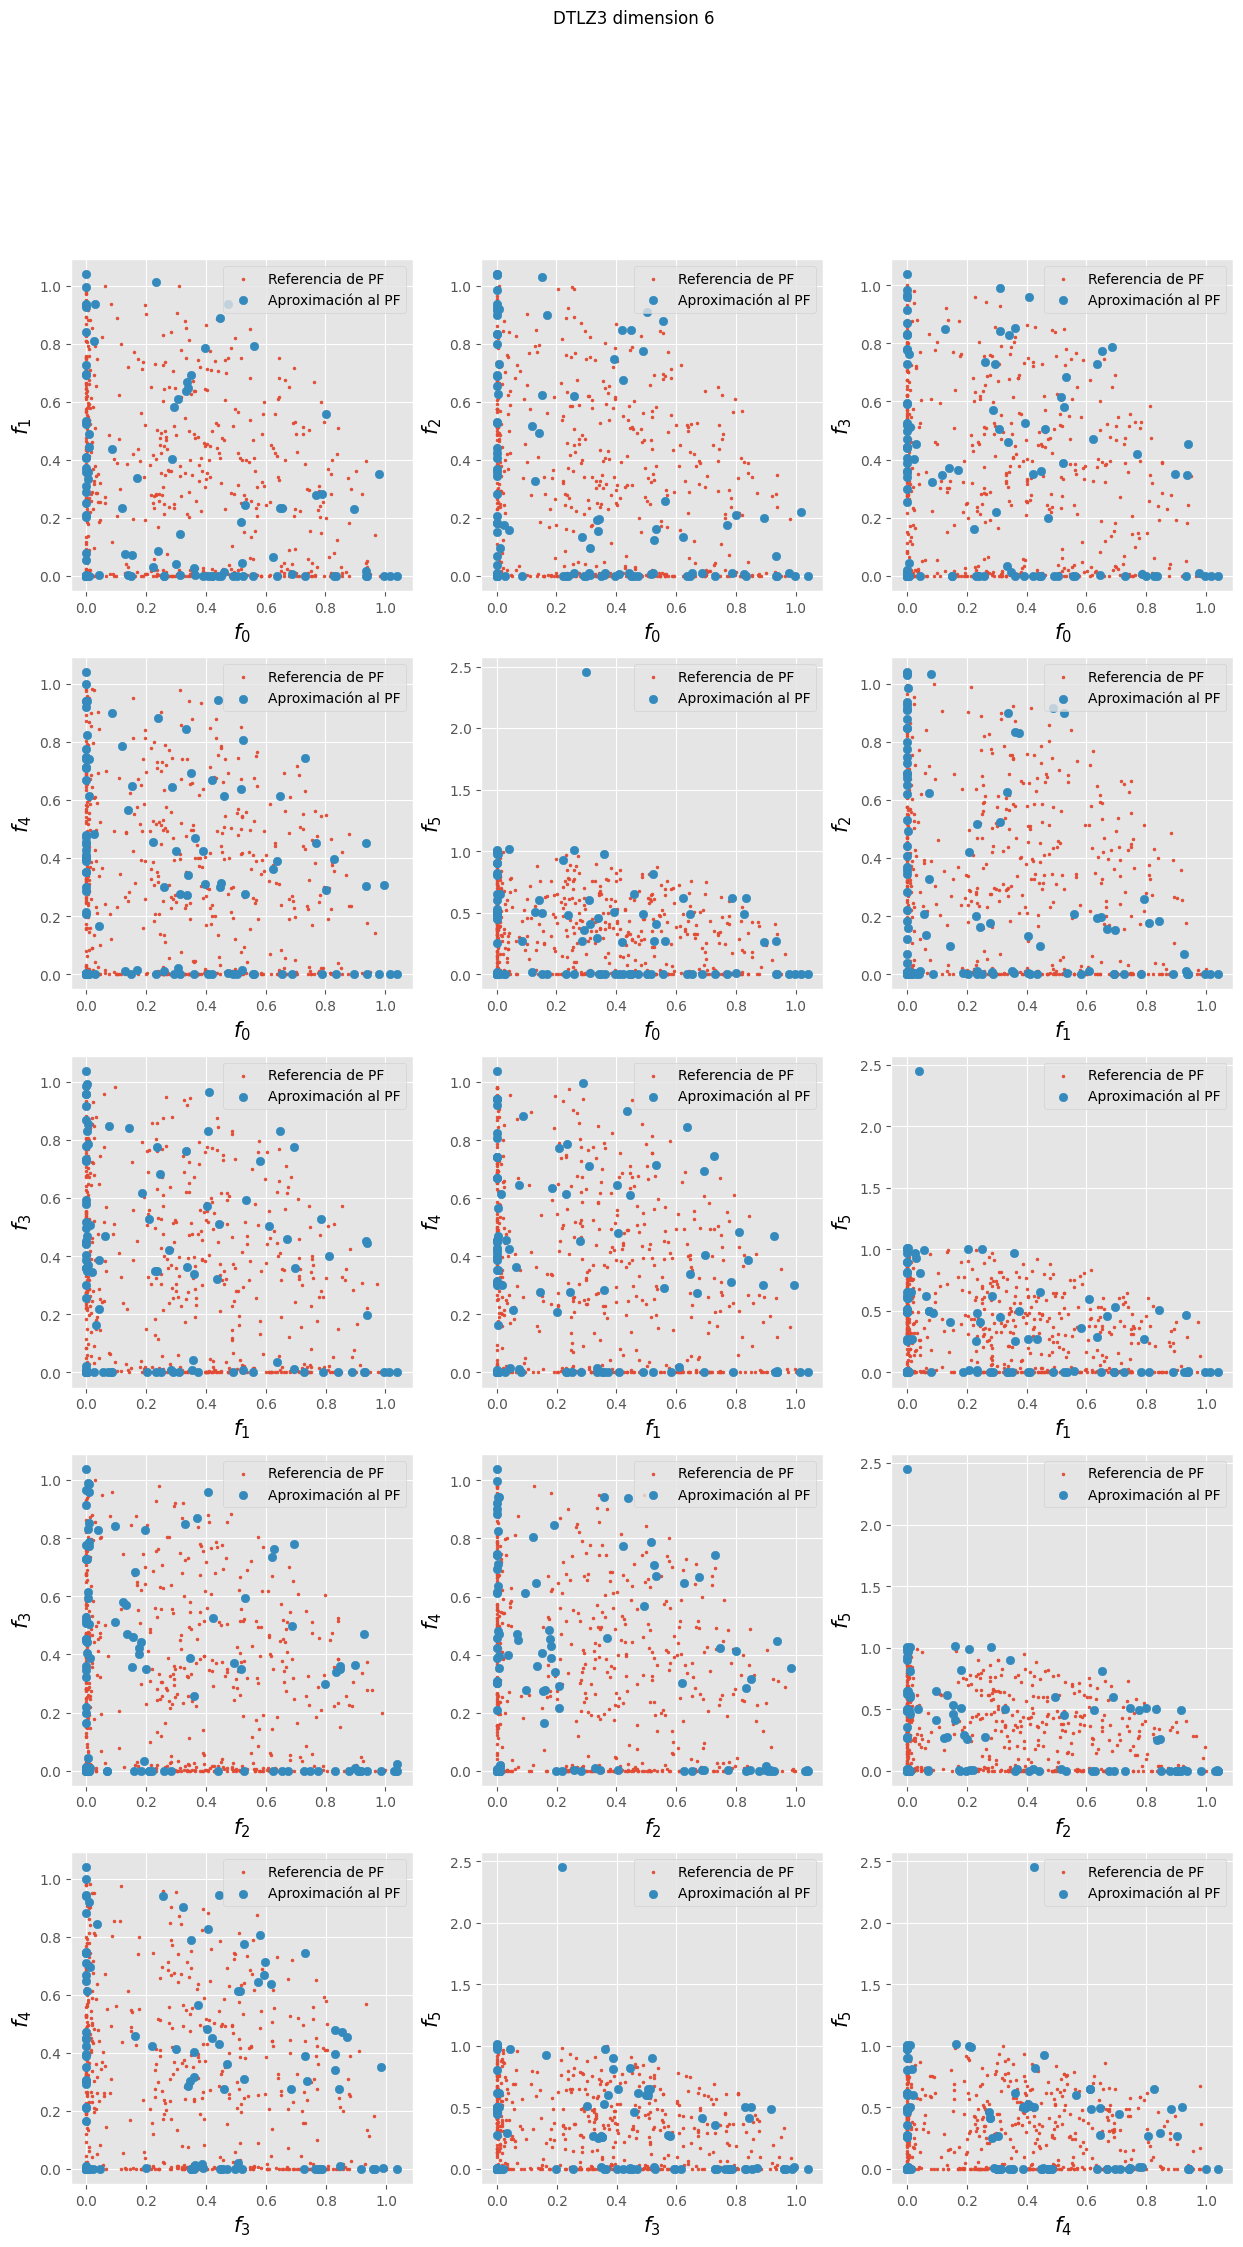

w_0                        0.001         0.100         0.200         0.300  \
problema dimension                                                           
DTLZ1    2          8.737808e-01  8.738328e-01  8.738728e-01  8.739046e-01   
         3          9.717902e-01  9.708103e-01  9.715784e-01  9.716879e-01   
         4          9.937112e-01  9.935151e-01  9.935531e-01  9.935340e-01   
         5          9.983222e-01  9.983109e-01  9.983205e-01  9.983396e-01   
         6          9.993770e-01  9.993353e-01  9.992076e-01  9.992146e-01   
         7          9.977479e-01  9.996130e-01  9.996365e-01  9.995659e-01   
DTLZ2    2          3.210872e+00  3.210872e+00  3.210872e+00  3.210872e+00   
         3          7.406309e+00  7.405524e+00  7.400817e+00  7.406349e+00   
         4          1.551146e+01  1.552332e+01  1.552711e+01  1.552711e+01   
         5          3.163125e+01  3.162162e+01  3.161948e+01  3.162516e+01   
         6          6.367127e+01  6.369283e+01  6.370275e+01  6.370146e+01   
         7          1.277296e+02  1.277464e+02  1.277474e+02  1.277294e+02   
DTLZ3    2          3.204125e+00  2.962628e+00  3.198401e+00  3.200836e+00   
         3          7.401769e+00  7.392234e+00  7.398723e+00  7.400296e+00   
         4          1.553633e+01  1.552991e+01  1.552940e+01  1.549571e+01   
         5          3.160475e+01  3.160780e+01  3.160513e+01  3.157073e+01   
         6          6.177109e+01  6.161200e+01  5.929023e+01  5.708429e+01   
         7          9.189778e+01  6.935129e+01  8.147760e+01  8.400048e+01   
DTLZ4    2          2.847532e+00  2.847536e+00  2.847535e+00  2.847504e+00   
         3          6.669547e+00  6.649905e+00  6.660899e+00  6.648603e+00   
         4          1.472637e+01  1.473334e+01  1.472827e+01  1.472577e+01   
         5          3.111339e+01  3.112802e+01  3.111597e+01  3.111597e+01   
         6          6.253795e+01  6.254542e+01  6.254542e+01  6.254576e+01   
         7          1.245510e+02  1.245521e+02  1.245521e+02  1.245521e+02   
DTLZ5    2          3.210872e+00  3.210872e+00  3.210872e+00  3.210872e+00   
         3          6.090806e+00  6.094234e+00  6.096139e+00  6.095238e+00   
         4          1.178600e+01  1.179755e+01  1.177445e+01  1.178054e+01   
         5          2.229889e+01  2.223060e+01  2.230238e+01  2.231559e+01   
         6          4.122253e+01  4.098551e+01  4.116130e+01  4.170548e+01   
         7          7.484465e+01  7.454459e+01  7.263390e+01  6.815498e+01   
DTLZ6    2          3.210873e+00  3.210874e+00  3.210873e+00  3.210873e+00   
         3          6.093803e+00  6.096105e+00  6.095513e+00  6.095646e+00   
         4          1.172410e+01  1.175288e+01  1.177250e+01  1.178520e+01   
         5          1.684667e+01  1.798910e+01  1.657659e+01  1.709009e+01   
         6          4.812429e+00  6.758947e+00  8.827700e+00  8.575106e+00   
         7          5.266933e-01  1.449566e+01  1.080372e+01  6.573483e+00   
DTLZ7    2          1.772554e+01  1.772555e+01  1.772555e+01  1.772555e+01   
         3          1.626102e+01  1.629826e+01  1.628249e+01  1.631554e+01   
         4          1.466283e+01  1.473385e+01  1.465812e+01  1.469554e+01   
         5          1.286379e+01  1.285206e+01  1.286730e+01  1.287038e+01   
         6          1.085073e+01  1.082939e+01  1.084472e+01  1.084419e+01   
         7          9.097442e+00  9.112337e+00  9.110461e+00  9.108257e+00   
WFG1     2          6.599027e+00  6.587985e+00  6.609729e+00  6.594359e+00   
         3          5.493638e+01  5.404647e+01  5.402077e+01  5.394634e+01   
         4          4.569205e+02  4.607826e+02  4.632003e+02  4.604797e+02   
         5          4.710118e+03  4.750376e+03  4.711942e+03  4.726937e+03   
         6          5.801096e+04  5.886865e+04  5.883390e+04  5.883390e+04   
         7          8.206812e+05  8.124966e+05  8.056885e+05  8.096920e+05   
WFG2     2          1.097082e+01  1.098136e+01  1.106526e+01  1.100254e+01   
         3          9.

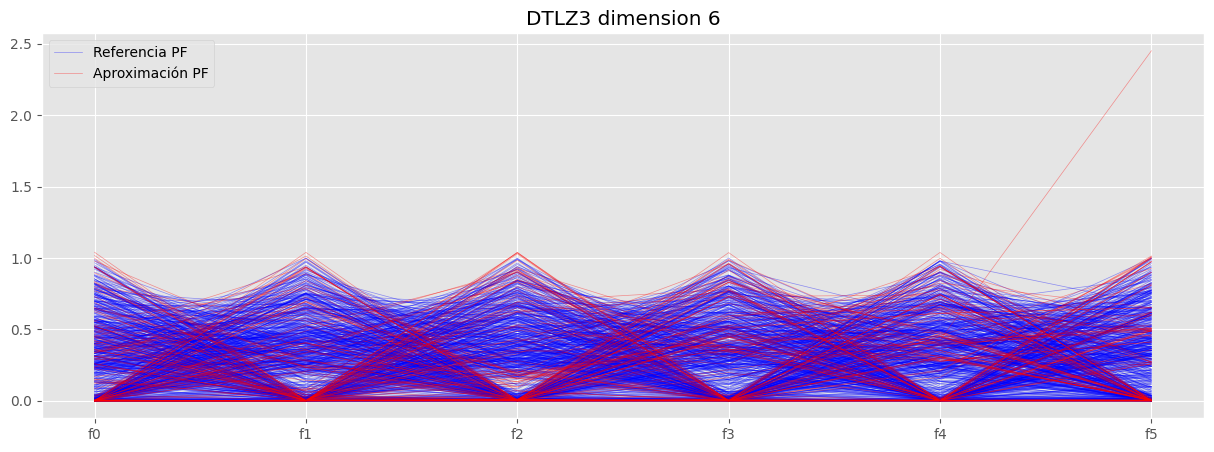

In [7]:
def diag_probl(problema,n_objetivos,df_PI, ind_conv='IGDp',aggfunc='mean',indicador='HV',run=0):
    '''Regresa los pairplots, los boxplots y la tabla del indicador pedido'''
    plot_prob(problema,n_objetivos,problema,run,ind_conv=ind_conv)
    get_boxplot(problema,n_objetivos,indicador,df_PI=df_PI)
    
    return get_tabla(indicador,df_PI,aggfunc=aggfunc)
problema='DTLZ3'
n_objetivos=6

pd.set_option('display.max_rows', None)
diag_probl(problema=problema,n_objetivos=n_objetivos,df_PI=df_todos_PI_IGDp)
diag_probl(problema=problema,n_objetivos=n_objetivos,df_PI=df_todos_PI_R2,ind_conv='R2')

# Tablas


Se realizan tablas que tienen la siguiente estructura

<div style='text-align: center;'>
    <img src='./img/Estructura de la tabla.png' width='900'/>
</div>



In [8]:
def meanan(x):
    if not np.isnan(x).all():
        return np.mean(x) 
    return 0

df_mean = get_tabla("SPD", df_todos_PI_R2, meanan)

df_mean= df_mean.applymap(format_scientific_6_digits)
df_mean=df_mean.replace(to_replace='0.000000e+00',value=np.nan)
pd.set_option("display.max_rows", None)
df_mean

w_0                         0.001          0.100          0.200  \
problema dimension                                                
DTLZ1    2           4.536767e+00   4.536089e+00   4.535493e+00   
         3           9.280008e+00   9.373912e+00   9.129893e+00   
         4           1.531657e+01   1.482531e+01   1.478564e+01   
         5           2.343937e+01   2.517998e+01   2.403186e+01   
         6           2.978987e+01   3.396351e+01   3.178349e+01   
         7           3.493495e+01   4.040144e+01   3.572622e+01   
DTLZ2    2           8.823804e+00   8.823803e+00   8.823802e+00   
         3           3.336667e+01   3.328611e+01   3.327849e+01   
         4           7.003182e+01   7.020684e+01   7.008158e+01   
         5           9.613098e+01   9.626678e+01   9.620396e+01   
         6           1.091110e+02   1.089562e+02   1.089765e+02   
         7           1.068123e+02   1.062280e+02   1.068438e+02   
DTLZ3    2           8.850813e+00   9.624594e+00   8.883237e+00   
         3           3.404233e+01   3.420746e+01   3.416242e+01   
         4           6.840641e+01   6.941787e+01   6.876803e+01   
         5           9.199738e+01   9.244336e+01   9.346036e+01   
         6           9.888186e+01   1.024498e+02   9.172342e+01   
         7           3.010874e+01   3.876906e+01   4.647623e+01   
DTLZ4    2           6.283551e+00   6.276036e+00   6.277113e+00   
         3           2.015659e+01   2.015030e+01   2.014093e+01   
         4          -3.744288e+15  -3.682331e+15  -3.682331e+15   
         5           4.535861e+01   5.182794e+01   5.148660e+01   
         6           2.866178e+01   2.932371e+01   2.932371e+01   
         7           2.674681e+01   2.690394e+01   2.690394e+01   
DTLZ5    2           8.823804e+00   8.823803e+00   8.823802e+00   
         3           8.804711e+00   8.816659e+00   8.817280e+00   
         4           7.724299e+01   7.615094e+01   7.718794e+01   
         5           1.067782e+02   1.075853e+02   1.067017e+02   
         6           1.148417e+02   1.152571e+02   1.155403e+02   
         7           1.106926e+02   1.139106e+02   1.160646e+02   
DTLZ6    2           8.823808e+00   8.823504e+00   8.823807e+00   
         3           9.197047e+00   9.000935e+00   8.903833e+00   
         4           9.586311e+01   9.594763e+01   9.573541e+01   
         5           1.032821e+02   1.147004e+02   1.150840e+02   
         6           1.163326e+02   1.163553e+02   1.168864e+02   
         7           1.166949e+02   1.166323e+02   1.157916e+02   
DTLZ7    2           1.085618e+01   1.085581e+01   1.085719e+01   
         3           4.226389e+01   4.355933e+01   4.364353e+01   
         4           7.649777e+01   8.478626e+01   8.077089e+01   
         5           1.075566e+02   1.078775e+02   1.079568e+02   
         6           1.150319e+02   1.150467e+02   1.148495e+02   
         7           1.165456e+02   1.166319e+02   1.168045e+02   
WFG1     2           2.111398e+01   2.112295e+01   2.109944e+01   
         3           8.820248e+01   8.817134e+01   8.818899e+01   
         4           1.056268e+02   1.122410e+02   1.121549e+02   
         5           1.164363e+02   1.165114e+02   1.164865e+02   
         6           1.158163e+02   1.154589e+02   1.154451e+02   
         7           1.118478e+02   1.062518e+02   1.064993e+02   
WFG2     2           2.159153e+01   2.162275e+01   2.214071e+01   
         3           8.461487e+01   8.278787e+01   8.328511e+01   
         4           1.016220e+02   1.001770e+02   9.731738e+01   
         5           1.079296e+02   1.104293e+02   1.097364e+02   
         6           1.157099e+02   1.167510e+02   1.168195e+02   
         7           1.179425e+02   1.173466e+02   1.181520e+02   
WFG3     2           2.309515e+01   2.309934e+01   2.309703e+01   
         3           7.150718e+01   7.260279e+01   7.247578e+01   
         4           1.138831e+02   1.144500e+02   1.139540e+02   
         5           1.174482e+02   1.172300e+0

In [9]:
def stdnan(x):
    if not np.isnan(x).all():
        return np.mean(x) 
    return 0

df_std = get_tabla("SPD", df_todos_PI_R2, stdnan)

df_std= df_std.applymap(format_scientific_6_digits)
df_std=df_std.replace(to_replace='0.000000e+00',value=np.nan)
pd.set_option("display.max_rows", None)


In [11]:
(df_mean.astype(str)+' +- '+df_std.astype(str)).replace('nan +- nan',np.nan).to_csv('../tablas_generadas/SPD_mean_std_QI_R2.csv')

# Guardando todos los boxplots

In [3]:
lista_indicadores=['hv','eps+','igd','igd+','r2','s-energy','spd']
lista_problemas=['DTLZ1', 'DTLZ2', 'DTLZ3', 'DTLZ4', 'DTLZ5', 'DTLZ6', 'DTLZ7',
       'WFG1', 'WFG2', 'WFG3', 'WFG4', 'WFG5', 'WFG6', 'WFG7', 'WFG8',
       'WFG9']

go_to_Assesment()

n_objetivos_lista=[3,5,7,10]
for prob in lista_problemas:
    for indicador in lista_indicadores:
        for dim in n_objetivos_lista:
            get_boxplot(prob,dim,indicador,df_todos_PI,save_img_path=f'../boxplots/{prob}_{str(dim).zfill(2)}D_{indicador}.png')

Se encontró el conjunto de referencia en Assessment


w_0                        0.001         0.100         0.200         0.300  \
problema dimension                                                           
DTLZ1    2          8.737332e-01  8.738353e-01  8.737860e-01  8.737337e-01   
         3          9.741830e-01  9.741781e-01  9.742376e-01  9.742308e-01   
         4          9.943723e-01  9.943554e-01  9.943363e-01  9.944041e-01   
         5          9.983130e-01  9.985335e-01  9.985888e-01  9.986197e-01   
         6          9.994048e-01  9.994637e-01  9.994861e-01  9.994887e-01   
         7          9.945803e-01  9.983252e-01  9.967195e-01  9.997228e-01   
         10         9.986168e-01  9.985225e-01  9.984148e-01  9.008029e-01   
DTLZ2    2          3.211126e+00  3.211150e+00  3.211165e+00  3.211146e+00   
         3          7.420452e+00  7.421833e+00  7.422530e+00  7.423038e+00   
         4          1.555123e+01  1.556201e+01  1.556635e+01  1.556944e+01   
         5          3.157355e+01  3.160761e+01  3.164219e+01  3.166270e+01   
         6          6.347544e+01  6.356662e+01  6.362324e+01  6.368913e+01   
         7          1.130190e+02  1.269320e+02  1.272484e+02  1.272087e+02   
         10         1.014274e+02  7.781823e+02  8.278518e+02  7.114440e+02   
DTLZ3    2          3.199758e+00  3.201541e+00  3.201467e+00  3.204273e+00   
         3          7.392184e+00  7.400334e+00  7.392408e+00  7.390249e+00   
         4          1.544610e+01  1.547380e+01  1.550173e+01  1.551565e+01   
         5          3.141834e+01  3.146147e+01  3.006963e+01  3.154970e+01   
         6          6.324117e+01  6.230040e+01  5.299494e+01  3.772970e+01   
         7          7.605746e+01  3.203618e+01  2.709172e+01  6.955848e+01   
         10         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
DTLZ4    2          2.847790e+00  2.847785e+00  2.847791e+00  2.847806e+00   
         3          6.667975e+00  6.668173e+00  6.668901e+00  6.668854e+00   
         4          1.466324e+01  1.461470e+01  1.467355e+01  1.467549e+01   
         5          3.116590e+01  3.116905e+01  3.118109e+01  3.118324e+01   
         6          6.251018e+01  6.252286e+01  6.251573e+01  6.252538e+01   
         7          1.243949e+02  1.245147e+02  1.244333e+02  1.244966e+02   
         10         1.010879e+03  1.010879e+03  1.010879e+03  1.010879e+03   
DTLZ5    2          3.211126e+00  3.211150e+00  3.211165e+00  3.211146e+00   
         3          6.104044e+00  6.104197e+00  6.104000e+00  6.104140e+00   
         4          1.171822e+01  1.168188e+01  1.171162e+01  1.171469e+01   
         5          2.210989e+01  2.185006e+01  2.197621e+01  2.168941e+01   
         6          3.671263e+01  3.810108e+01  4.053636e+01  4.000370e+01   
         7          4.012466e+01  4.049006e+01  4.191701e+01  5.294841e+01   
         10         2.412940e+02  1.912292e+02  1.726752e+02  1.845806e+02   
DTLZ6    2          3.211177e+00  3.211164e+00  3.211169e+00  3.211168e+00   
         3          6.104775e+00  6.104793e+00  6.104811e+00  6.104775e+00   
         4          1.133701e+01  1.178836e+01  1.168022e+01  1.178294e+01   
         5          1.531698e+00  1.103762e+00  4.139065e+00  6.786975e+00   
         6          4.263591e+00  4.217272e+00  4.217272e+00  4.217272e+00   
         7          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
         10         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
DTLZ7    2          1.772570e+01  1.772572e+01  1.772574e+01  1.772573e+01   
         3          1.636810e+01  1.636925e+01  1.634131e+01  1.633989e+01   
         4          1.466354e+01  1.468138e+01  1.467919e+01  1.464786e+01   
         5          1.267113e+01  1.278867e+01  1.286734e+01  1.291543e+01   
         6          1.034723e+01  1.079577e+01  1.101807e+01  1.112907e+01   
         7          8.473341e+00  8.948850e+00  9.119047e+00  9.207368e+00   
         10         2.248617e+00  2.515916e+00  2.214282e+00  2.277505e+00   
WFG1     2          6.

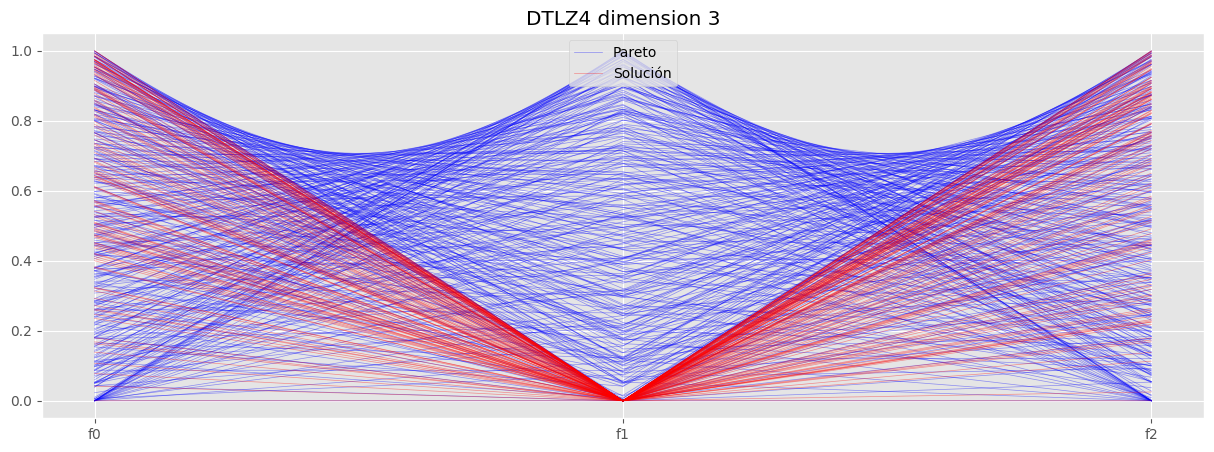

In [24]:
diag_probl('DTLZ4',3,df_PI=df_todos_PI)